The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Softmax Regression Implementation from Scratch
:label:`sec_softmax_scratch`

Because softmax regression is so fundamental,
we believe that you ought to know
how to implement it yourself.
Here, we limit ourselves to defining the
softmax-specific aspects of the model
and reuse the other components
from our linear regression section,
including the training loop.


In [2]:
import torch
from d2l import torch as d2l

## The Softmax

Let's begin with the most important part:
the mapping from scalars to probabilities.
For a refresher, recall the operation of the sum operator
along specific dimensions in a tensor,
as discussed in :numref:`subsec_lin-alg-reduction`
and :numref:`subsec_lin-alg-non-reduction`.
[**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis.**]
The `axis` variable lets us compute row and column sums:


In [3]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [4]:
# Testing
import time
test1 = torch.rand(20, 500)
test1 *= 32
test1.sum(0, keepdims=True), test1.sum(1, keepdims=True)

(tensor([[301.7871, 375.4119, 300.7739, 296.4152, 332.2306, 340.3048, 323.0245,
          302.2380, 364.3810, 257.2242, 271.3541, 370.7757, 342.1058, 353.7587,
          341.9388, 287.0809, 292.5823, 314.6967, 316.2196, 279.4128, 375.2801,
          306.0309, 270.0435, 353.5085, 259.8061, 258.8352, 293.8320, 312.8132,
          309.7886, 325.2498, 308.9695, 331.9055, 207.3215, 274.3171, 364.3621,
          322.4642, 287.2700, 387.5707, 329.4793, 242.2712, 323.8468, 305.6369,
          312.0054, 317.0487, 346.1542, 334.5101, 293.9353, 300.3771, 280.9047,
          335.4640, 288.9056, 285.2281, 330.0281, 292.0199, 310.6461, 277.9869,
          315.6418, 329.3320, 354.7622, 344.5796, 303.1617, 326.8216, 347.5973,
          348.8695, 394.8348, 299.5376, 371.8587, 332.6358, 343.6275, 340.0424,
          360.0380, 367.3025, 285.9659, 308.7340, 292.6151, 331.7879, 309.2408,
          297.4194, 332.2722, 361.6707, 286.7144, 309.1178, 385.6579, 325.1921,
          219.7262, 277.1188, 325.5338, 

Computing the softmax requires three steps:
(i) exponentiation of each term;
(ii) a sum over each row to compute the normalization constant for each example;
(iii) division of each row by its normalization constant,
ensuring that the result sums to 1:

(**
$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.$$
**)

The (logarithm of the) denominator
is called the (log) *partition function*.
It was introduced in [statistical physics](https://en.wikipedia.org/wiki/Partition_function_(statistical_mechanics))
to sum over all possible states in a thermodynamic ensemble.
The implementation is straightforward:


In [5]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [6]:
# Testing

def test_softmax(test1):
  test1_e = torch.exp(test1)
  partition_test = test1_e.sum(1, keepdims=True)
  return test1_e / partition_test

tic = time.time()
test_softmax(test1)
f'{time.time() - tic:.2f} sec'

'0.01 sec'

For any input `X`, [**we turn each element
into a nonnegative number.
Each row sums up to 1,**]
as is required for a probability. Caution: the code above is *not* robust against very large or very small arguments. While it is sufficient to illustrate what is happening, you should *not* use this code verbatim for any serious purpose. Deep learning frameworks have such protections built in and we will be using the built-in softmax going forward.


In [7]:
X = torch.rand((2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1503, 0.2250, 0.1506, 0.1713, 0.3028],
         [0.1118, 0.2201, 0.2375, 0.2218, 0.2088]]),
 tensor([1., 1.]))

In [8]:
# Testing
test3 = torch.rand((20,50))
test3_prob = softmax(test3)
test3_prob.sum(1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000])

## The Model

We now have everything that we need
to implement [**the softmax regression model.**]
As in our linear regression example,
each instance will be represented
by a fixed-length vector.
Since the raw data here consists
of $28 \times 28$ pixel images,
[**we flatten each image,
treating them as vectors of length 784.**]
In later chapters, we will introduce
convolutional neural networks,
which exploit the spatial structure
in a more satisfying way.


In softmax regression,
the number of outputs from our network
should be equal to the number of classes.
(**Since our dataset has 10 classes,
our network has an output dimension of 10.**)
Consequently, our weights constitute a $784 \times 10$ matrix
plus a $1 \times 10$ row vector for the biases.
As with linear regression,
we initialize the weights `W`
with Gaussian noise.
The biases are initialized as zeros.


In [9]:
class SoftmaxRegressionScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

The code below defines how the network
maps each input to an output.
Note that we flatten each $28 \times 28$ pixel image in the batch
into a vector using `reshape`
before passing the data through our model.


In [10]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [11]:
# Testing
def forward_test(self, input):
  #reshape input so each pixel corresponds with a feature
  input = input.reshape(-1, self.W.shape[0])
  #standard forward pass. multiply input by weights, add bias, then softmax to get logits
  return softmax(torch.matmul(input, self.W) + self.b)


## The Cross-Entropy Loss

Next we need to implement the cross-entropy loss function
(introduced in :numref:`subsec_softmax-regression-loss-func`).
This may be the most common loss function
in all of deep learning.
At the moment, applications of deep learning
easily cast as classification problems
far outnumber those better treated as regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
For efficiency we avoid Python for-loops and use indexing instead.
In particular, the one-hot encoding in $\mathbf{y}$
allows us to select the matching terms in $\hat{\mathbf{y}}$.

To see this in action we [**create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`.**]
The correct labels are $0$ and $2$ respectively (i.e., the first and third class).
[**Using `y` as the indices of the probabilities in `y_hat`,**]
we can pick out terms efficiently.


In [12]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [13]:
# Testing
y_test = torch.tensor([1,0,1,2])
y_pred = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5], [0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# outputs pairwise coordinates of the matrix based off of the values of the vectors
y_pred[[0,1,2,3], y_test]

tensor([0.3000, 0.3000, 0.3000, 0.5000])

Now we can (**implement the cross-entropy loss function**) by averaging over the logarithms of the selected probabilities.


In [14]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

cross_entropy(y_hat, y)

tensor(1.4979)

In [15]:
@d2l.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return cross_entropy(y_hat, y)

## Training

We reuse the `fit` method defined in :numref:`sec_linear_scratch` to [**train the model with 10 epochs.**]
Note that the number of epochs (`max_epochs`),
the minibatch size (`batch_size`),
and learning rate (`lr`)
are adjustable hyperparameters.
That means that while these values are not
learned during our primary training loop,
they still influence the performance
of our model, both vis-à-vis training
and generalization performance.
In practice you will want to choose these values
based on the *validation* split of the data
and then, ultimately, to evaluate your final model
on the *test* split.
As discussed in :numref:`subsec_generalization-model-selection`,
we will regard the test data of Fashion-MNIST
as the validation set, thus
reporting validation loss and validation accuracy
on this split.


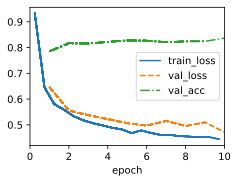

In [16]:
data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]


In [21]:
# assigns features and correct class to X and y respectively
X, y = next(iter(data.val_dataloader()))

# stores the index of the predicted class in a [256, 1] array
preds = model(X).argmax(axis=1)
preds.shape

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


torch.Size([256])

We are more interested in the images we label *incorrectly*. We visualize them by
comparing their actual labels
(first line of text output)
with the predictions from the model
(second line of text output).


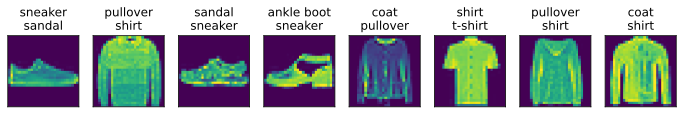

In [24]:
# compares every index from preds and y, returns an [256, 1] boolean array with 1 when the stored indices where predicted and actual differ
wrong = preds.type(y.dtype) != y

# boolean indexing, X[wrong] selects all the rows with a value of 1 (so prediction was wrong), same for others, so only mistakes remain
X, y, preds = X[wrong], y[wrong], preds[wrong]

# turns indices into text labels, and groups each true label and wrong prediciton label pair using zip
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]

# displays each image in X, and the corresponding label strings in labels
data.visualize([X, y], labels=labels)

## Summary

By now we are starting to get some experience
with solving linear regression
and classification problems.
With it, we have reached what would arguably be
the state of the art of 1960--1970s of statistical modeling.
In the next section, we will show you how to leverage
deep learning frameworks to implement this model
much more efficiently.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in :numref:`sec_softmax` this can cause numerical instabilities.
    1. Test whether `softmax` still works correctly if an input has a value of $100$.
    1. Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$?
    1. Implement a fix by looking at the value relative to the largest entry in the argument.
1. Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$.
    1. Try it out in the code example of this section.
    1. Why do you think it runs more slowly?
    1. Should you use it? When would it make sense to?
    1. What do you need to be careful of? Hint: consider the domain of the logarithm.
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?
1. Experiment with the hyperparameters of the code in this section. In particular:
    1. Plot how the validation loss changes as you change the learning rate.
    1. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?


In [55]:
# Code for Exercise 1
import math

def e1_softmax(e1):
  test_e1 = torch.exp(e1)
  partition_test = test_e1.sum(1, keepdims=True)
  return test_e1 / partition_test

e1 = torch.tensor([100, 120, 150, 122]).reshape(1, -1)

e1_softmax(e1)

# 1.3
def e1_p3_softmax(e1_p3):
  max = torch.max(e1_p3)
  test_e1_p3 = torch.exp(e1_p3 - max)
  partition_test = test_e1_p3.sum(1, keepdims=True)
  return test_e1_p3 / partition_test

e1_p3 = torch.tensor([1, 2, 3, 9]).reshape(1, -1)

print(torch.finfo(torch.float32).max)
print(torch.finfo(torch.float32).max)
hundred = torch.tensor([100])
e1_p3_softmax(e1), e1_softmax(e1), math.exp(100), torch.exp(hundred)

3.4028234663852886e+38
3.4028234663852886e+38


(tensor([[1.9287e-22, 9.3576e-14, 1.0000e+00, 6.9144e-13]]),
 tensor([[nan, nan, nan, nan]]),
 2.6881171418161356e+43,
 tensor([inf]))

Exercise 1

1.

No, it does not work. This is due to float overflow, and returns nan for the first sample for input:
e1 = torch.tensor([100,91,22,40]).reshape(1, -1)

2.

Yes, it can. It takes smaller negative values for the outputs to become nan, however. Like going smaller than -100 doesn't cause integer underflow. Only if you push it to like e^-190 does this happen. This is because e^-x is between 0 and 1. So only when e^-x becomes so tiny it is 0, you get nan from 0/0

3.

We can use the equivalence
logsumexp(x_i+b))
= logsumexp(x_i)*exp(b))
= logexp(b*sum(exp(x_i))
= b + logsumexp(x_i)

So then our partition function becomes X.max + logsumexp(x_i - X.max), and our numerator becomes exp(x_i - X.max)

Implementation (you don't actually need the max in partition here, that is only the case if you will be using it in context of log-softmax or log-likelihood):
def e1_p3_softmax(e1_p3):
  max = torch.max(e1_p3)
  test_e1_p3 = torch.exp(e1_p3 - max)
  partition_test = test_e1_p3.sum(1, keepdims=True) + max
  return test_e1_p3 / partition_test


In [78]:
# Code for Exercise 2

from sklearn.preprocessing import OneHotEncoder
import numpy as np

data_encoded = y.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded_data = encoder.fit_transform(data_encoded)


def cross_entropy_e2(y_hat, y_onehot):

    onehot = -torch.log(torch.sum(y_hat, y_onehot)).mean

cross_entropy(y_hat, one_hot_encoded_data)

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [2], [34, 8]

Exercise 2

1.

This is just the one-hot version of cross entropy loss.

2.

It runs more slowly because for n samples with d classes, the index version of cross entropy loss does n logs, n sums, and a divide. However, the one-hot version does n*d multiplications, then n logs, n sums, and a divide. Because you have to multiply every logit by the onehot vector.

3.

Would probably not use it, because there literally is no point for single class problems. However, this is useful for classification tasks with multiple correct classes or soft labels (from label smoothing, distillation targets, etc).


4.

If you log before summing, then most operations are invalid because log(0) is not valid, as domain of log is positive.